Optimal Total Distance: 174 

Salesman 1 Route: [(1, 5), (5, 1)]
Salesman 1 Specific Distance: 32
Salesman 2 Route: [(1, 6), (6, 1)]
Salesman 2 Specific Distance: 62
Salesman 3 Route: [(1, 2), (2, 3), (3, 4), (4, 1)]
Salesman 3 Specific Distance: 80


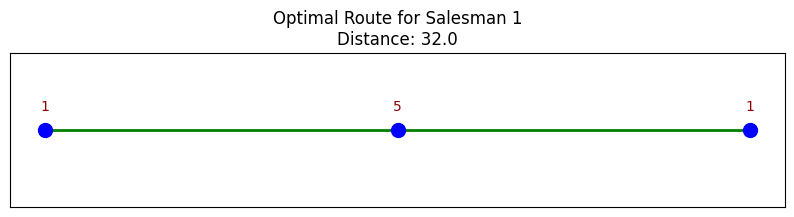

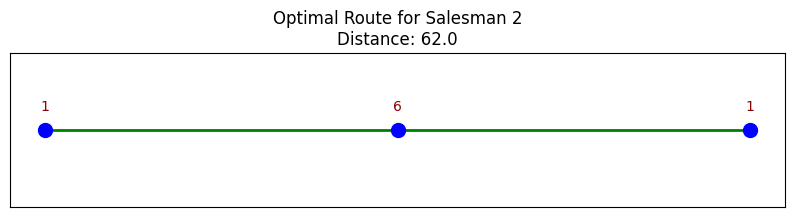

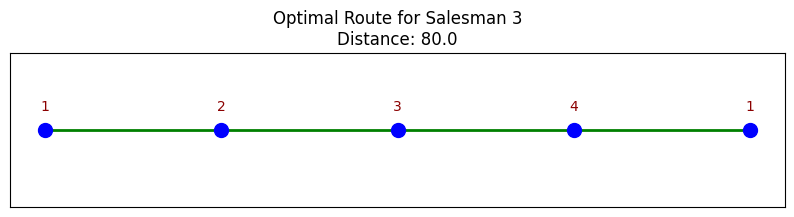

In [5]:
#!pip install pyomo
#!apt-get install -y -qq glpk-utils
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np

def solve_multi_tsp_with_pyomo(distance_matrix, num_salesmen, depot=1, show_route=True):
    """
    Solve the Multi-Traveling Salesman Problem (MTSP) using Pyomo.

    Parameters:
    - distance_matrix (2D list or numpy array): Matrix of distances between cities.
    - num_salesmen (int): Number of salesmen available.
    - depot (int): Starting city for all salesmen (default is 1, indexed from 1).
    - show_route (bool): If True, displays a plot of the optimal routes. Defaults to True.
    """
    # Number of cities
    n = len(distance_matrix)

    # Create a Pyomo model
    model = ConcreteModel()

    # Sets
    model.CITIES = RangeSet(1, n)  # Cities
    model.SALESMEN = RangeSet(1, num_salesmen)  # Salesmen
    model.EDGES = [(i, j) for i in range(1, n+1) for j in range(1, n+1) if i != j]  # All directed edges (i, j)

    # Parameters
    model.distance = Param(model.CITIES, model.CITIES, initialize=lambda model, i, j: distance_matrix[i-1][j-1])

    # Decision Variables
    model.x = Var(model.EDGES, model.SALESMEN, domain=Binary)  # x[i, j, k] = 1 if salesman k travels i -> j
    model.u = Var(model.CITIES, within=NonNegativeReals)  # MTZ constraints for subtour elimination

    # Objective: Minimize total travel distance
    def obj_function(model):
        return sum(model.distance[i, j] * model.x[i, j, k] for i, j in model.EDGES for k in model.SALESMEN)
    model.OBJ = Objective(rule=obj_function, sense=minimize)

    # Constraints
    # 1. Each city (except the depot) is visited exactly once
    def visit_constraint(model, j):
        if j != depot:
            return sum(model.x[i, j, k] for i in model.CITIES if i != j for k in model.SALESMEN) == 1
        else:
            return Constraint.Skip
    model.VisitConstraint = Constraint(model.CITIES, rule=visit_constraint)

    # 2. Each salesman must leave the depot exactly once
    def depot_start_constraint(model, k):
        return sum(model.x[depot, j, k] for j in model.CITIES if j != depot) == 1
    model.DepotStartConstraint = Constraint(model.SALESMEN, rule=depot_start_constraint)

    # 3. Each salesman must return to the depot exactly once
    def depot_end_constraint(model, k):
        return sum(model.x[i, depot, k] for i in model.CITIES if i != depot) == 1
    model.DepotEndConstraint = Constraint(model.SALESMEN, rule=depot_end_constraint)

    # 4. Flow conservation: If a salesman enters a city, they must leave it
    def flow_conservation_constraint(model, j, k):
        if j != depot:
            return (sum(model.x[i, j, k] for i in model.CITIES if i != j) ==
                    sum(model.x[j, m, k] for m in model.CITIES if m != j))
        else:
            return Constraint.Skip
    model.FlowConservationConstraint = Constraint(model.CITIES, model.SALESMEN, rule=flow_conservation_constraint)

    # 5. Subtour elimination (MTZ constraints)
    def subtour_elimination_constraint(model, i, j):
        if i != depot and j != depot and i != j:
            return model.u[i] - model.u[j] + n * sum(model.x[i, j, k] for k in model.SALESMEN) <= n - 1
        else:
            return Constraint.Skip
    model.SubtourEliminationConstraint = Constraint(model.CITIES, model.CITIES, rule=subtour_elimination_constraint)

    # Solve the model
    result = SolverFactory('glpk').solve(model)

    # Extract and display the results
    routes = {k: [] for k in model.SALESMEN}
    total_distances = {k: 0 for k in model.SALESMEN}

    for k in model.SALESMEN:
        current_city = depot
        while True:
            for j in model.CITIES:
                if current_city != j and model.x[current_city, j, k].value == 1:
                    routes[k].append((current_city, j))
                    total_distances[k] += distance_matrix[current_city-1][j-1]
                    current_city = j
                    break
            if current_city == depot:
                break

    # Print the results
    print("Optimal Total Distance:", sum(total_distances[k] for k in model.SALESMEN), "\n")
    for k in model.SALESMEN:
        print(f"Salesman {k} Route: {routes[k]}")
        print(f"Salesman {k} Specific Distance: {total_distances[k]}")

    # Plot the routes if enabled
    if show_route:
        for k, route in routes.items():
            plot_optimal_route_linear(route, total_distances[k], salesman_id=k)


def plot_optimal_route_linear(optimal_tour, total_distance, salesman_id=1):
    """
    Plots the optimal route in a line for a single salesman's TSP.

    Parameters:
    - optimal_tour (list of tuples): Optimal path, e.g., [(1, 3), (3, 4), (4, 2), (2, 1)].
    - total_distance (float): Total distance of the optimal tour for this specific salesman.
    - salesman_id (int): Identifier for the salesman.
    """
    # Extract the order of cities from the optimal tour
    ordered_cities = [optimal_tour[0][0]]  # Start with the first city in the tour
    for _, next_city in optimal_tour:
        ordered_cities.append(next_city)

    # Generate positions along a line for each city in the order of the optimal tour
    x_coords = list(range(1, len(ordered_cities) + 1))
    y_coords = [1] * len(ordered_cities)  # Set a constant y-coordinate for all cities to place them in a line

    # Create a figure
    plt.figure(figsize=(10, 2))
    plt.title(f"Optimal Route for Salesman {salesman_id}\nDistance: {total_distance:.1f}")

    # Plot each city in the order of the optimal tour
    plt.scatter(x_coords, y_coords, color='blue', s=100, zorder=5)

    # Annotate each city with its index according to the ordered tour
    for i, (x, y) in enumerate(zip(x_coords, y_coords)):
        plt.text(x, y + 0.05, f'{ordered_cities[i]}', ha='center', color='darkred')

    # Plot the route by drawing lines in the order of the optimal tour
    for idx in range(len(ordered_cities) - 1):
        plt.plot([x_coords[idx], x_coords[idx + 1]], [1, 1], color='green', linestyle='-', linewidth=2)

    # Set plot limits and remove the y-axis for a clean linear view
    plt.ylim(0.8, 1.2)
    plt.xlabel("Cities")
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().get_xaxis().set_visible(False)
    plt.show()


# Example usage
if __name__ == "__main__":
    distance_matrix = [
        [0, 29, 20, 21, 16, 31],
        [29, 0, 15, 29, 28, 40],
        [20, 15, 0, 15, 14, 25],
        [21, 29, 15, 0, 25, 35],
        [16, 28, 14, 25, 0, 30],
        [31, 40, 25, 35, 30, 0]
    ]
    num_salesmen = 3
    solve_multi_tsp_with_pyomo(distance_matrix, num_salesmen, depot=1, show_route=True)